In [631]:
import numpy as np
from enum import Enum

class Kernel(Enum):
    POLYNOMIAL_KERNEL = "polynomial",
    GAUSSIAN_KERNEL = "gaussian",
    SIGMOID_KERNEL = "sigmoid",
    NONE = "none"# add mode kernels here

class SVM:
    def __init__(self, C = 1.0, kernel: Kernel = Kernel.NONE, degree: int = 2, homogenous: bool = False, sigma: float = 1.0, k: float = 1.0, delta: float = 0.0) -> None:
        self.C = C # regularization parameter
        self.kernel = kernel # kernel function
        self.degree = degree
        self.homogenous = homogenous
        self.sigma = sigma
        self.k = k
        self.delta = delta

    def computeDotProduct(self, w: np.array, b: float, x: np.array, y: float) -> float:
        return 1 - y * self.computePrediction(w,b,x)

    def computePrediction(self, w: np.array, b: float, x: np.array) -> float:
        return np.dot(w,x.T) + b
    
    def polynomialKernel(self, x1: np.array, x2: np.array) -> float: 
        coef = 1 if self.homogenous else 0
        return (coef + x1.dot(x2)) ** self.degree

    def gaussianKernel(self, x1: np.array, x2: np.array) -> float:
        return np.exp(-np.linalg.norm(x1-x2)**2 / (2 * (self.sigma ** 2)))
    
    def sigmoidKernel(self, x1: np.array, x2: np.array) -> float:
        return np.tanh(self.k * x1.dot(x2) - self.delta)
    
    def kernelToValue(self, kernel: Kernel, x1: np.array, x2: np.array) -> float:
        if kernel == Kernel.POLYNOMIAL_KERNEL:
            return self.polynomialKernel(x1,x2)
        elif kernel == Kernel.GAUSSIAN_KERNEL:
            return self.gaussianKernel(x1,x2)
        elif kernel == Kernel.SIGMOID_KERNEL:
            return self.sigmoidKernel(x1,x2)
        else:
            raise Exception("Kernel not implemented")

    def hingeloss(self, w: np.array, b: float, x: np.ndarray, y: np.array) -> float:
        # check if the dimensions are correct
        regularizer: float = 0.5 * np.linalg.norm(w) ** 2
        loss: float = regularizer
        for i in range(x.shape[0]):
            optimizationTerm: float = self.computeDotProduct(w,b,x[i],y[i]) # since the w and x are vectors, horizontal ones, we need to transpose x
            loss += self.C * max(0,optimizationTerm)
        return loss
    
    def updateX(self, X: np.ndarray, l: np.ndarray, kernel: Kernel) -> np.ndarray:
        modifiedX = np.zeros((X.shape[0],l.shape[0]))
        for i in range(X.shape[0]):
            for j in range(l.shape[0]):
                modifiedX[i][j] = self.kernelToValue(kernel,X[i],l[j])
        
        return modifiedX

    def __fit(self, X: np.ndarray, Y: np.ndarray, batchSize: int = 100, learningRate: float = 0.001, epochs: int = 1000) -> (np.array, float,  list):
        if self.kernel != Kernel.NONE:
            self.l = np.copy(X)
            X = self.updateX(X, self.l, self.kernel)  
        
        numberOfFeatures: int = X.shape[1]
        numberOfSamples: int = X.shape[0]
        ids = np.arange(numberOfSamples) # ids of the samples
        np.random.shuffle(ids) # shuffle the ids
        w: np.array = np.zeros((1,numberOfFeatures))[0]
        b: float = 0
        losses: list = []

        for _ in range(epochs):
            loss = self.hingeloss(w,b,X,Y)
            losses.append(loss)

            for batchInitial in range(0,numberOfSamples,batchSize):
                gradW: float = 0
                gradB: float = 0
                for j in range (batchInitial, batchInitial + batchSize):
                    if j < numberOfSamples:
                        optimizationTerm: float = self.computeDotProduct(w,b,X[ids[j]],Y[ids[j]])
                        if optimizationTerm > 0:
                            gradW += self.C * Y[ids[j]] * X[ids[j]]
                            gradB += self.C * Y[ids[j]]
                w = w - learningRate * w + learningRate * gradW
                b = b + learningRate * gradB
        return w,b,losses

    def fit(self, X: np.ndarray, Y: np.ndarray, batchSize: int = 100, learningRate: float = 0.001, epochs: int = 1000) -> (np.array, float,  list):
        classes: int = len(np.unique(Y))
        if self.kernel != Kernel.NONE:
            w: np.array = np.zeros((classes,X.shape[0]))
        else:
            w: np.array = np.zeros((classes,X.shape[1]))
        b: np.array = np.zeros(classes)
        losses: list = []

        if classes == 2:
            yTemp = np.copy(Y)
            yTemp[yTemp != 1] = -1
            yTemp[yTemp == 1] = 1
            w, b, loss = self.__fit(X,yTemp,batchSize=batchSize,learningRate=learningRate,epochs=epochs)
            losses.append(loss)
            return w,b,losses
        
        for i in range(classes):
            print(i+1,"'th class out of ", classes)
            yTemp = np.copy(Y)
            yTemp[yTemp != i] = -1
            yTemp[yTemp == i] = 1
            w[i], b[i], loss = self.__fit(X,yTemp,batchSize=batchSize,learningRate=learningRate,epochs=epochs)
            losses.append(loss)

        return w,b, losses

    def predict(self, X: np.ndarray, w: np.ndarray, b: float) -> np.array:
        if self.kernel != Kernel.NONE:
            X = self.updateX(X, self.l, self.kernel)
        if w.ndim > 1:
            prediction = np.matmul(X,w.T) +b 
            return np.argmax(prediction,axis=1)
        else:
            prediction = self.computePrediction(w,b,X)
            return np.sign(prediction)
        
    def accuracy(self, X: np.ndarray, Y: np.ndarray, w: np.ndarray, b: float) -> float:
        predictions = self.predict(X,w,b)
        return np.mean(predictions == Y)
    
    def printStatistics(self, X: np.ndarray, Y: np.ndarray, w: np.array, b: np.array, loss: list) -> None:
        print("Accuracy: ", self.accuracy(X,Y,w,b))
        print("Loss: ", loss)
        print("predict:", self.predict(X,w,b))
        print("w:", w)
        print("b: ", b)
        

$$\min {\frac {1}{2} \|w\|^2} + C_i \cdot \sum_{i=1}^n \max{\{0,1-y_n(w^Tx+b)\}}$$

In [632]:
svm = SVM()
# print(SVM.hingeloss(np.array([1,2]),1,np.array([[1,2],[3,4],[5,6]]),np.array([1,-1,1])))
w, b, losses = svm.fit(np.array([[1,2],[3,4],[5,6]]),np.array([1,-1,1]))
print(w,b,losses)
print(svm.predict(np.array([[1,2],[3,4],[5,6]]),w,b))

svm = SVM(kernel=Kernel.POLYNOMIAL_KERNEL)
w, b, losses = svm.fit(np.array([[1,2,3],[3,4,3]]),np.array([1,-1]))
print(w,b,losses)
print(svm.predict(np.array([[1,2,3],[3,4,5],[5,6,5]]),w,b))

[-0.07281361  0.16554549] 0.3840000000000003 [[3.0, 2.9740124999999997, 2.9480749500125, 2.922187250187425, 2.8963493008743004, 2.8705610026218524, 2.8448222561776118, 2.8191329624875126, 2.7934930226955004, 2.7679023381431316, 2.742360810369183, 2.7168683411092553, 2.691424832295378, 2.66603018605562, 2.6406843047136945, 2.6153870907885715, 2.590138446994086, 2.5649382762385446, 2.5397864816243434, 2.5146829664475767, 2.4896276341976478, 2.4646203885568863, 2.439661133400161, 2.414749772794494, 2.3898862109986783, 2.365070352462892, 2.3677279213347853, 2.3589968332200373, 2.3688372292571565, 2.3645499729598516, 2.3583282047632492, 2.3700959694497827, 2.3613601476068524, 2.3621092974489306, 2.3669109276949634, 2.358181472750501, 2.3658776486023445, 2.3637370157475326, 2.3553693151158743, 2.369285407601799, 2.360551206072003, 2.3591518606807713, 2.3661043680380343, 2.357376525406326, 2.362921650926208, 2.3629344368730316, 2.3542129309337225, 2.3666787146356807, 2.35977557138958, 2.35615

In [633]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Creating dataset
X, y = datasets.make_blobs(
        n_samples = 100, # Number of samples
        n_features = 2, # Features
        centers = 2,
        cluster_std = 1,
        random_state=41
    )

# Classes 1 and -1
y = np.where(y == 0, -1, 1)

In [634]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

svm = SVM()

w, b, losses = svm.fit(X_train, y_train)

loss = losses.pop()

svm.printStatistics(X_test,y_test, w,b,loss)
# print("X_test", X_test)
# print("y_test", y_test)

Accuracy:  1.0
Loss:  [50.0, 6.767087400000399, 2.080904903093643, 4.149100563549742, 1.552180346767067, 0.27779231866002513, 0.0989478671035527, 0.09875007031721271, 0.0985526689266486, 0.09835566214146425, 0.09815904917284346, 0.09796282923354693, 0.09776700153790907, 0.09856097777046771, 0.09840864269364481, 0.09821192381690022, 0.09801559818119022, 0.09781966500042602, 0.09762412349009018, 0.0974289728672335, 0.0972342123504719, 0.09703984115998332, 0.0968458585175045, 0.09665226364632803, 0.09645905577129901, 0.09626623411881217, 0.09607379791680869, 0.095881746394773, 0.09569007878372983, 0.09549879431624116, 0.09530789222640297, 0.09511737174984239, 0.09492723212371448, 0.09473747258669916, 0.09454809237899836, 0.09435909074233274, 0.09417046691993881, 0.09398222015656588, 0.09379434969847289, 0.09360685479342565, 0.09341973469069358, 0.09323298864104687, 0.09304661589675345, 0.09286061571157583, 0.09267498734076836, 0.09248973004107418, 0.09230484307072208, 0.0921203256894237, 

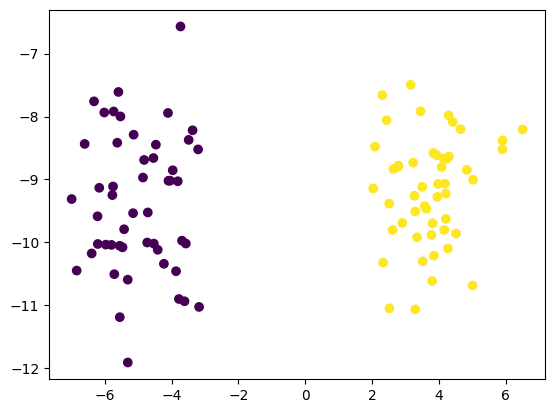

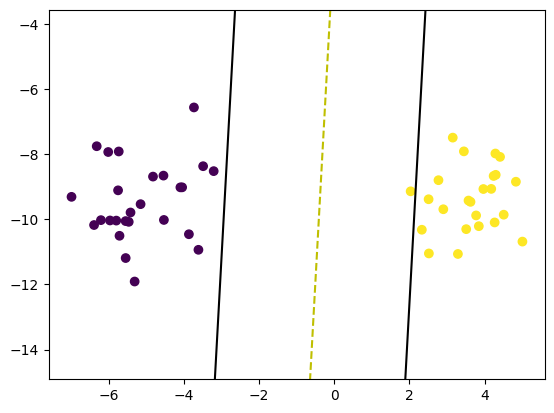

In [635]:
# Visualizing the scatter plot of the dataset
def visualize_dataset(X: np.ndarray = X, y: np.ndarray = y):
    plt.scatter(X[:, 0], X[:, 1], c=y)


# Visualizing SVM
def visualize_svm(w: np.array,b: float, X: np.ndarray, XTest: np.ndarray, yTest: np.ndarray):
    # split w to w and b where b is first element of w
    # b = w[0]
    # w = w[1:] 

    def get_hyperplane_value(x, w, b, offset):
        return (-w[0] * x + b + offset) / w[1]

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.scatter(XTest[:, 0], XTest[:, 1], marker="o", c=yTest)

    x0_1 = np.amin(XTest[:, 0])
    x0_2 = np.amax(XTest[:, 0])

    x1_1 = get_hyperplane_value(x0_1, w, b, 0)
    x1_2 = get_hyperplane_value(x0_2, w, b, 0)

    x1_1_m = get_hyperplane_value(x0_1, w, b, -1)
    x1_2_m = get_hyperplane_value(x0_2, w, b, -1)

    x1_1_p = get_hyperplane_value(x0_1, w, b, 1)
    x1_2_p = get_hyperplane_value(x0_2, w, b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

    x1_min = np.amin(X[:, 1])
    x1_max = np.amax(X[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])

    plt.show()


visualize_dataset(X, y)
visualize_svm(w, b, X, X_test, y_test)

Kernels

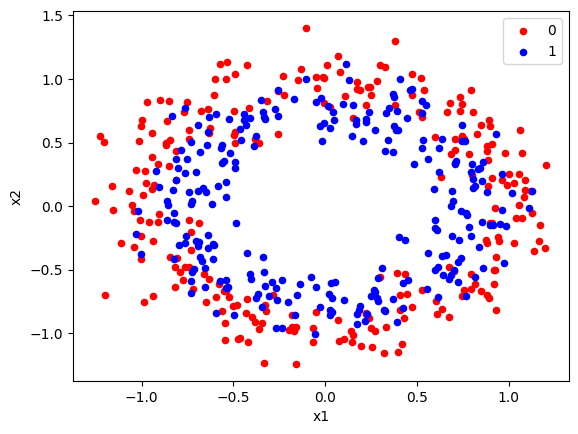

In [636]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=500, noise=0.13, random_state=42)

df = pd.DataFrame(dict(x1=X[:, 0], x2=X[:, 1], y=y))

colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('y')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x1', y='x2', label=key, color = colors[key])
plt.show()

In [637]:
y[y == 0] = -1 # change to -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm = SVM()

w, b, losses = svm.fit(X_train, y_train)

# Loss value
loss = losses.pop()

svm.printStatistics(X_test,y_test,w,b,loss)

Accuracy:  0.46
Loss:  [350.0, 349.9930473500845, 349.9861293739904, 349.979245878184, 349.97239667034404, 349.96558155935065, 349.95880035528205, 349.9520528694015, 349.9453389141511, 349.93865830314473, 349.93201085115805, 349.92539637412204, 349.9188146891132, 349.91226561434854, 349.9057489691766, 349.89926457406693, 349.892812250606, 349.8863918214889, 349.8800031105111, 349.87364594255945, 349.86732014360905, 349.8610255407098, 349.85476196198516, 349.84852923662083, 349.8423271948579, 349.8361556679878, 349.8300144883427, 349.8239034892901, 349.8178225052255, 349.8117713715631, 349.80574992473385, 349.7997580021736, 349.79379544231807, 349.78786208459684, 349.7819577694262, 349.77608233820166, 349.7702356332921, 349.7644174980332, 349.7586277767198, 349.75286631460176, 349.74713295787393, 349.7414275536733, 349.7357499500709, 349.7300999960656, 349.72447754157827, 349.71888243744434, 349.7133145354095, 349.707773688122, 349.70225974912785, 349.696772572864, 349.6913120146511, 34

In [638]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
svm = SVM(kernel=Kernel.GAUSSIAN_KERNEL)

w, b, losses = svm.fit(X_train, y_train)
loss = losses.pop()

svm.printStatistics(X_test,y_test,w,b,loss)

Accuracy:  0.6866666666666666
Loss:  [350.0, 385.6629078486709, 346.82361319111635, 340.44703275357995, 333.9067450564492, 345.79229301486555, 360.49859220244906, 356.2322001060519, 372.2591798936528, 368.98811249925075, 339.7333930807937, 365.8025728078072, 354.7408885088184, 333.7873281044605, 324.54609035138003, 343.21525334899343, 328.7765426223522, 318.93643315713064, 315.9809845542774, 321.8077405196843, 339.2108316766111, 363.98766474663444, 343.049921012006, 327.7547523633713, 328.0183385257442, 331.4580147818998, 332.1756971005124, 342.9282995164254, 337.588292543632, 331.9283070143117, 328.0392698021176, 329.13330746847316, 329.9150915555178, 340.5678999149839, 335.2799252866187, 329.6259567442356, 325.74268773721565, 326.8861664572544, 328.719497317329, 322.04585045924637, 325.7079533682068, 336.60637291957295, 331.46917476378167, 318.2618703281352, 321.12286652041695, 322.1907756790793, 322.93977954315466, 323.8866663243584, 317.39991489318146, 327.6765672165725, 330.357158

In [639]:
import plotly.express as px

df['x1^2'] = df['x1'] ** 2
df['x2^2'] = df['x2'] ** 2
df['x1 * x2'] = df['x1'] * df['x2']
df['x1^2 + x2^2'] = df['x1'] ** 2 + df['x2'] **2

fig = px.scatter_3d(df, x='x1', y='x2', z='x1 * x2', color='y')
fig.show()

In [640]:
fig = px.scatter_3d(df, x='x1^2', y='x2^2', z='x1 * x2', color='y')
fig.show()

In [641]:
fig = px.scatter_3d(df, x='x1', y='x2', z='x1^2 + x2^2', color='y')
fig.show()

In [642]:
# lets imagine we want to classify n classes from a data set
# we can use one vs rest method
# basically we will train n different classifiers, one for each class

from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm = SVM(kernel=Kernel.GAUSSIAN_KERNEL)
w,b,losses = svm.fit(X_train,y_train)

svm.printStatistics(X_test,y_test,w,b,losses.pop())
print(losses)


1 'th class out of  3
2 'th class out of  3
3 'th class out of  3
Accuracy:  1.0
Loss:  [105.0, 71.6240130429953, 48.05441788694609, 37.052753766042805, 29.47636039771073, 25.407254259575545, 24.35024576625954, 23.589291495043515, 23.082101882186315, 22.60510508078263, 22.250832255866477, 21.943828499683956, 21.67864533242821, 21.40389943651426, 21.179221757529877, 20.93338102963127, 20.73644285566997, 20.54545941403938, 20.383957143752415, 20.14472770534666, 19.999774159687487, 19.868114766281288, 19.737603292694335, 19.595101681246746, 19.49201849121392, 19.350738963500653, 19.22055753541524, 19.1047953321587, 18.966990010139515, 18.850396005512465, 18.72346012731531, 18.59490457586368, 18.469656925583095, 18.346232610680108, 18.229196337149805, 18.105240817871987, 17.9822870110395, 17.860619557356717, 17.739225030206818, 17.62009908031578, 17.501364713895395, 17.38120110923429, 17.26036421500039, 17.139879949348785, 17.0218183124551, 16.915865843656974, 16.805391044382002, 16.688058

In [651]:
# lets imagine we want to classify n classes from a data set
# we can use one vs rest method
# basically we will train n different classifiers, one for each class

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler

iris = load_digits()
X = iris.data
y = iris.target
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
# fit_transform use to do some calculation and then do transformation

# X_train = scaler.fit_transform(X_train)  # data normalization
# X_test = scaler.transform(X_test)

# svm = SVM(kernel=Kernel.POLYNOMIAL_KERNEL, degree=3)
svm = SVM(kernel=Kernel.NONE)
w,b,losses = svm.fit(X_train,y_train)

svm.printStatistics(X_test,y_test,w,b,losses.pop())
print(losses)

(1797, 64)
1 'th class out of  10
2 'th class out of  10
3 'th class out of  10
4 'th class out of  10
5 'th class out of  10
6 'th class out of  10
7 'th class out of  10
8 'th class out of  10
9 'th class out of  10
10 'th class out of  10
Accuracy:  0.924074074074074
Loss:  [1257.0, 475.87418001794725, 455.8257082727643, 177.59999325719247, 146.3426860777956, 130.5255741058497, 169.26137452841965, 147.86776033837066, 738.8202122010176, 143.49038595780272, 179.0346313717631, 206.39022447156617, 182.4094345545125, 100.47307912291552, 118.50908357489928, 162.76671832412154, 219.9296304538631, 130.6978325665225, 153.53262464400945, 65.25626697208025, 45.41584296126155, 67.83021383497812, 396.16383236378306, 288.927341323262, 94.60666219597374, 119.97795881505118, 1757.9668370236695, 237.31707165059822, 151.72323084130613, 206.69225615762556, 58.555565864132134, 221.25747973493645, 182.43795673819128, 112.1069784225351, 196.22925123354648, 271.61144914810205, 182.97043208607818, 158.3218

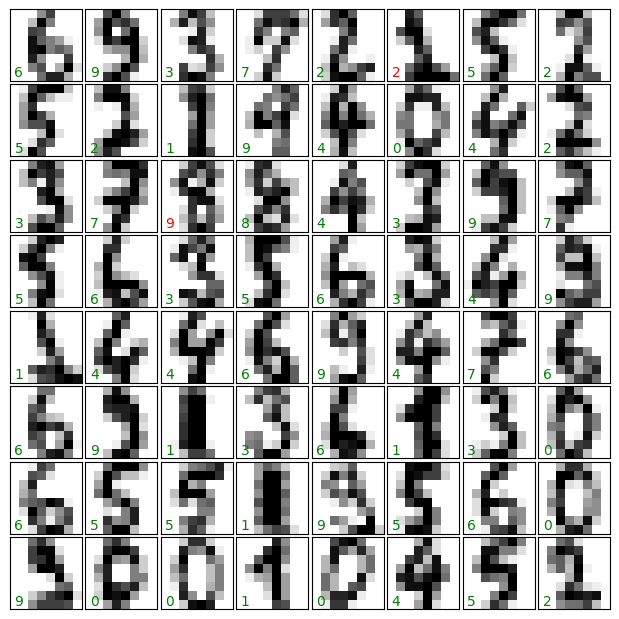

In [652]:
predicted = svm.predict(X_test,w,b)

fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test.reshape(-1, 8, 8)[i], cmap=plt.cm.binary,
              interpolation='nearest')

    # label the image with the target value
    if predicted[i] == y_test[i]:
        ax.text(0, 7, str(predicted[i]), color='green')
    else:
        ax.text(0, 7, str(predicted[i]), color='red')